# Interpreting the model

First, load the model weights:

In [1]:
import numpy as np

fn = "model_128_64_32_1_wts.npz"

wts = np.load("models/%s" % fn)['wts']

Here's what was stored:

In [2]:
for w in wts:
    print(w.shape)

(10000, 128)
(128, 256)
(64, 256)
(256,)
(64, 32)
(32,)
(32, 1)
(1,)


Note that 256 = 4 x 64, the number of input gates to 64 LSTM units. So (128, 256)(64, 256)(256,) are the input weight to these LSTMs. Then (64, 32)(32,) are the weights from the LSTMs (plus bias) to the dense 32-feedforward layer. And (32, 1)(1,) are the weights to the single output unit.

The bottom layer (10000, 128) is the learned 128-dimensional vector representation of the 10000 most common words. This representation is the first thing we want to examine.

We'll use the TDA-mapper-t-SNE visualisation of <a href="https://github.com/box121209/wikiwords">https://github.com/box121209/wikiwords</a>. As input to this we'll need three files:

<ul>
<li>
<tt>data/wdict.txt</tt>
<li>
<tt>data/wvectors.txt</tt>
<li>
<tt>data/wcounts.txt</tt>
</ul>

First, read the data:

In [5]:
import pandas as pd, numpy as np
import json

train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')

#wall = ' '.join(train['comment_text']).split()

with open('models/tok_words.txt', 'r') as ifp1:
    tok = json.load(ifp1)

with open('models/tok_word_ct.txt', 'r') as ifp2:
    ct = json.load(ifp2)

The file <tt>'data/wdict.txt'</tt>:

In [14]:
#def idx(w):
#    n = len(tok[w])
#    if n==0: return 0
#    elif n==1: return tok[w][0]
#    else: return tok[w][1]

ofp = open('./data/wdict.txt', 'w')
for w in tok.keys():
    i = tok[w]
    if i==0: continue
    ofp.write("%s %d\n" % (w.encode('utf-8').replace(' ','.'), i))
ofp.close()

The file <tt>'data/wvectors.txt'</tt>:

In [15]:
ofp = open('./data/wvectors.txt', 'w')
for w in tok.keys():
    str = w.encode('utf-8')
    i = tok[w]  
    if i==0: continue
    vec = wts[0][i]
    for j in range(128):
        str += " %g" % vec[j]
    str += "\n"
    ofp.write(str)
ofp.close()

The file <tt>'data/wcounts.txt'</tt>:

In [16]:
ofp = open('./data/wcounts.txt', 'w')
for w in ct.keys():
    ofp.write("%d %s\n" % (ct[w], w.encode('utf-8')))
ofp.close()

In [17]:
import commands

cmd = "wc -l data/*"
print(commands.getoutput(cmd))

   19813 data/wcounts.txt
   19813 data/wdict.txt
   19813 data/wvectors.txt
   59439 total


## t-SNE visualisation

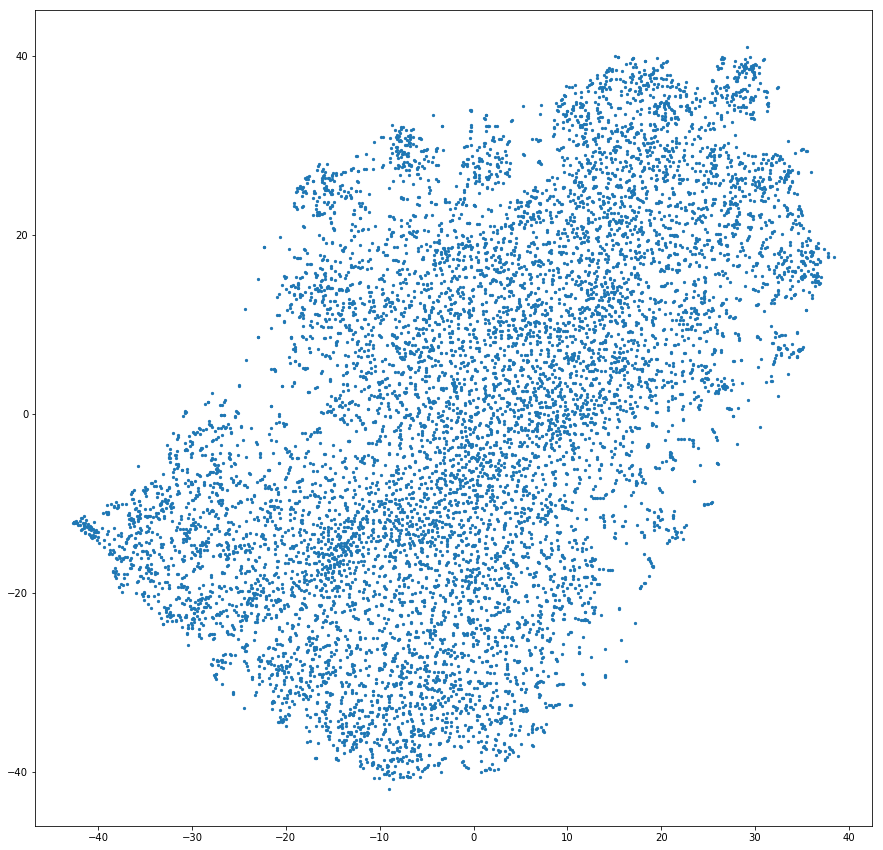

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt
from tsne import bh_sne

w2v = wts[0].astype(float)
w2v_2d = bh_sne(w2v, theta=0.2)

plt.figure(figsize=(15,15))
plt.scatter(w2v_2d[:,0], w2v_2d[:,1], s=5)
plt.show()

## TDA mapper visualisation

Produce a TDA Shiny visualisation of this word2vec representation? 

HOWEVER: at present there is a problem with the recursive clustering which I don't understand and which needs sorting out...

In [24]:
cmd = "$HOME/Projects/201801-wikiwords/wikiwords/make_shiny_pack.R ./data ./shiny/wordrep"
print(commands.getoutput(cmd))

Loading required package: methods

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: RColorBrewer
Checking for output directory...
Reading data...
Fitting frequency distribution...
  (Intercept) log(xx[cond]) 
    6.9624260    -0.9352188 
null device 
          1 
Plot written to ./shiny/wordrep/word_frequency_distribution.pdf
Building clusters (using 20 bins and average cluster size 32)...
Bin 1                           
Error: evaluation nested too deeply: infinite recursion / options(expressions=)?
Execution halted


To view this you'll need to open R in that directory and run the shiny app.

Next, let's do the same for the full comment representation that comes out of the top (32-dimensional) layer of the model.